In [48]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier
import numpy as np
from time import time
import pandas as pd

In [49]:

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 'from_poi_to_this_person', 
                 'exercised_stock_options', 'from_messages', 'other', 'from_this_person_to_poi', 
                 'long_term_incentive', 'shared_receipt_with_poi', 'restricted_stock', 'director_fees'] 

enron_data = pickle.load(open("final_project_dataset.pkl", "r") )
enron_data = pickle.load(open("final_project_dataset.pkl", "r") )
df = pd.DataFrame.from_records(list(enron_data.values()))

data = featureFormat(enron_data, features_list)
labels, features = targetFeatureSplit(data)



In [50]:
scv = StratifiedShuffleSplit(labels, 1000, random_state = 42)
RF_acc = []
RF_precision = []
RF_recall = []

svc_acc = []
svc_precision = []
svc_recall = []

LR_acc = []
LR_precision = []
LR_recall = []

In [53]:
def cvClassifier(clf, features, labels, cv):
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
    total_predictions = true_negatives + false_negatives + false_positives + true_positives
    accuracy = 1.0*(true_positives + true_negatives)/total_predictions
    precision = 1.0*true_positives/(true_positives+false_positives+1)
    recall = 1.0*true_positives/(true_positives+false_negatives)
    return accuracy, precision, recall



In [54]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
for i in range(len(features[0])):
    t0 = time()
    selector = SelectKBest(f_classif, k = i+1)
    selector.fit(features, labels)
    reduced_features = selector.fit_transform(features, labels)
    cutoff = np.sort(selector.scores_)[::-1][i]
    selected_features_list = [f for j, f in enumerate(features_list[1:]) if selector.scores_[j] >= cutoff]
    selected_features_list = ['poi'] + selected_features_list
    
    RF = RandomForestClassifier(random_state=1126)
    adaBoost = AdaBoostClassifier(random_state=1126)
    x = LogisticRegression (random_state=1126)
    s = SVC(random_state=1126)
    
    acc, precision, recall = cvClassifier(RF, reduced_features, labels, scv)
    RF_acc.append(acc)
    RF_precision.append(precision)
    RF_recall.append(recall)
    
    acc, precision, recall = cvClassifier(s, reduced_features, labels, scv)
    svc_acc.append(acc)
    svc_precision.append(precision)
    svc_recall.append(recall)

    acc, precision, recall = cvClassifier(x, reduced_features, labels, scv)
    LR_acc.append(acc)
    LR_precision.append(precision)
    LR_recall.append(recall)
    
    print "fitting time for k = {0}: {1}".format(i+1, round(time()-t0, 3))
    print "RF accuracy: {0}  precision: {1}  recall: {2}".format(RF_acc[-1], RF_precision[-1], RF_recall[-1])
    print "svc accuracy: {0}  precision: {1}  recall: {2}".format(svc_acc[-1], svc_precision[-1], svc_recall[-1])
    print "LR accuracy: {0}  precision: {1}  recall: {2}".format(LR_acc[-1], LR_precision[-1], LR_recall[-1])
    #print "TN = {0}: FN= {1}: FP = {2}: TP= {3}".format( true_negatives, false_negatives , false_positives , true_positives)



fitting time for k = 1: 79.744
RF accuracy: 0.847  precision: 0.360377358491  recall: 0.191
svc accuracy: 0.866666666667  precision: 0.0  recall: 0.0
LR accuracy: 0.865533333333  precision: 0.359375  recall: 0.0115
fitting time for k = 2: 79.526
RF accuracy: 0.8286  precision: 0.0878962536023  recall: 0.0305
svc accuracy: 0.866666666667  precision: 0.0  recall: 0.0
LR accuracy: 0.856866666667  precision: 0.102150537634  recall: 0.0095
fitting time for k = 3: 80.548
RF accuracy: 0.832266666667  precision: 0.079674796748  recall: 0.0245
svc accuracy: 0.866666666667  precision: 0.0  recall: 0.0
LR accuracy: 0.855133333333  precision: 0.00568181818182  recall: 0.0005
fitting time for k = 4: 81.641
RF accuracy: 0.835266666667  precision: 0.158959537572  recall: 0.055
svc accuracy: 0.866666666667  precision: 0.0  recall: 0.0
LR accuracy: 0.853333333333  precision: 0.0  recall: 0.0
fitting time for k = 5: 82.849
RF accuracy: 0.840333333333  precision: 0.198170731707  recall: 0.065
svc accurac

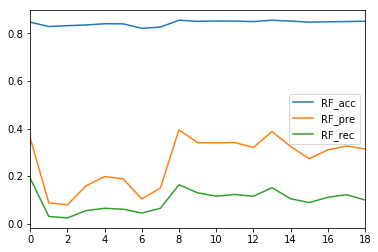

In [55]:
import matplotlib.pyplot as plt

rfdf = pd.DataFrame({'RF_acc': RF_acc, 'RF_pre': RF_precision, 'RF_rec': RF_recall})
svcdf = pd.DataFrame({'SVC_acc': svc_acc, 'SVC_pre': svc_precision, 'SVC_rec': svc_recall}) 
LRdf = pd.DataFrame({'LR_acc': LR_acc, 'LR_pre': LR_precision, 'LR_rec': LR_recall}) 

rfdf.plot()
plt.show()

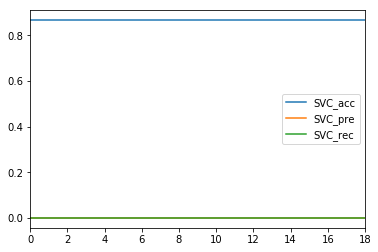

In [56]:
svcdf.plot()
plt.show()

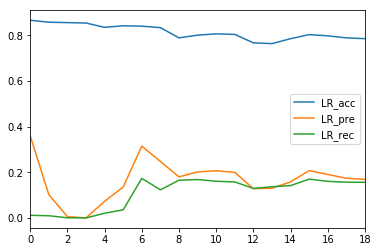

In [57]:


LRdf.plot()
plt.show()